# Clusterzição de clientes de uma loja de varejo online

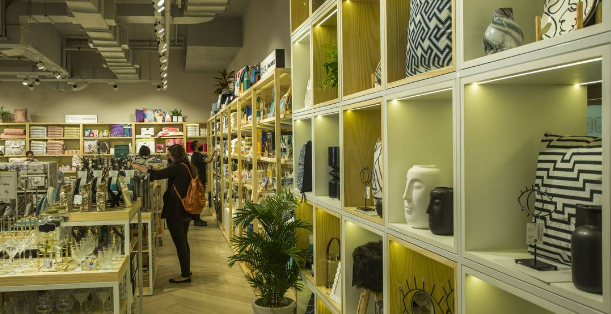

A clusterização de clientes é essencial para estratégia de marketing para direcionar promoções, recuperar clientes e ações em geral de campanha para atingir um tipo de cliente específico.
Vale ressaltar que é de muita importancia saber também se um cliente irá continuar a realizar compras com a loja ou não.

Pensando nisso iremos tratar neste notebook este tipo de problema, utilizando [os dados do kaggle](https://www.kaggle.com/datasets/hellbuoy/online-retail-customer-clustering) de compras online de uma loja.

Obs: Lembrando que estou utilizando o google colab para construir este notebook, [link do notebook no colab.](https://colab.research.google.com/drive/1WwUTNIIMkBJqp4z6NA1Ejuedasvzj0Sk#scrollTo=Hw_X5JtcQOX7)

Import de libs e leitura dos dados.

In [1]:
!pip install Lifetimes==0.11.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.1 MB/s eta 0:00:00


In [31]:
import pandas as pd
import numpy as np
from lifetimes import BetaGeoFitter as bgf
from lifetimes.utils import *
import seaborn as sns
import matplotlib.pyplot as plt

Irei ler estes dados que salvei na minha pasta do google drive.

In [3]:
df_sales = pd.read_csv('/content/drive/MyDrive/Fonte_Dados/Clustering_Oline_Retail/OnlineRetail.csv', encoding="ISO-8859-1")
df_sales.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


Verificando os dados nulos, podemos identificar que há costumer id nulos, neste caso poderia ser algum erro sistémico, o ideal para o tratamento destes ids,  seria utilizar nossa softskill de comunicação e informar o time dev para atuarmos em conjunto afim de tratar esse possível bug, pois não podemos incluir estes dados nulos no modelo, pois se este bug causar algum erro em pagamentos, por exemplo, estariamos clusterizando possíveis clientes que saibam deste bug e estariam realizando fraudes.
Neste exemplo iremos retira-los para não enviesar o modelo.

In [4]:
df_sales.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
df_sales.dropna(inplace=True)

In [6]:
df_sales.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

O Período de realização das transações são do dia 01/12/2010 à 09/12/2011.


In [7]:
df_sales['InvoiceDate'] = pd.to_datetime(df_sales['InvoiceDate'],format="%d-%m-%Y %H:%M")
df_sales.agg(InvoiceDate_min=('InvoiceDate', np.min), InvoiceDate_max=('InvoiceDate', np.max)).reset_index()

,index,InvoiceDate
0,InvoiceDate_min,2010-12-01 08:26:00
1,InvoiceDate_max,2011-12-09 12:50:00


In [8]:
df_sales.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

Iremos criar uma feature chamada "TotalPrice" afim de calcular o valor total da compra.

In [9]:
df_sales['TotalPrice'] = df_sales['UnitPrice'] * df_sales['Quantity']

In [10]:
df_sales.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


Funções responsáveis pela criação dos gráficos que iremos utilizar no notebook. Iremos utilizar a biblioteca plotly.

In [11]:
def line_plot(df, eixo_x, eixo_y, titulo):
  import plotly.express as px

  fig = px.line(df, x=eixo_x, y=eixo_y, title=titulo)
  
  return fig

def scatter_plot(df, eixo_x, eixo_y, cor, titulo):
  import plotly.express as px

  fig = px.scatter(df, x=eixo_x, y=eixo_y, color=cor, title=titulo)

  return fig

def bar_plot(df, eixo_x, eixo_y, cor, titulo):
  import plotly.express as px
  
  fig = px.bar(df, x=eixo_x, y=eixo_y, color=cor, title=titulo)

  return fig

Iremos utilizar os dados de recência, frequencia e monetário de cada clientes para realizar a clusterização, e esta função é responsável de criar e preparar o dataframe para a clusterização

In [12]:
def prepare_features(df):

  df = df.groupby('CustomerID').agg(InvoiceDate_min=('InvoiceDate', np.min), InvoiceDate_max=('InvoiceDate', np.max),
                                    Frequency=('InvoiceNo', pd.Series.nunique), Monetary=('TotalPrice', np.sum)).reset_index()

  df['Recency'] = pd.to_datetime('2011-12-10') - df['InvoiceDate_max']
  df['Recency'] = df['Recency'].astype("str")
  df['Recency'] = df['Recency'].apply(lambda x:x.split(" ")[0])
  df['Recency'] = df['Recency'].astype("int")

  df = df[['CustomerID', 'Recency', 'Frequency', 'Monetary']]

  return df

As vezes nos deparamos com problemas em que há casos que alguns tipos de cluster de clientes não necessáriamente um modelo de machine learning irá atender o time de negócio, as vezes uma simples regras de negócio já resolve o problema, pensando nisso trouxe dois exemplos:



*   Grupo de clientes inativos: Neste caso este cluster irá reunir clientes que tem uma recencia maior que a mediana da recência da base.
*   Grupo de clientes novos: Neste caso este cluster irá reunir clientes que tem uma recência igual a zero, ou seja a sua primeira transação.



In [13]:
def inative(df):
  df = prepare_features(df)
  median_recency = df['Recency'].median().tolist()
  
  df['cluster_name'] = np.where(df['Recency']>=median_recency,'Inative','Undefined')

  return df

In [14]:
def new_consumer(df):
  df = inative(df)

  df_inative= df.query('cluster_name == "Inative"')

  df_new = df.query('cluster_name == "Undefined"')
  df_new = df_new[['CustomerID', 'Recency', 'Frequency', 'Monetary']]
  df_new['cluster_name'] = np.where(df_new['Recency']==0,'New','Undefined')
  
  df_union = pd.concat([df_new, df_inative], ignore_index=True)

  return df_union

Iremos, nesta função, executar a analise de elbow, para verificar qual o número de cluser ideal para treinar o modelo.
Após seu output, podemos verificar que o número ideal de cluster são 3.

In [15]:
def elbow_analysis(df):
  from sklearn.preprocessing import StandardScaler
  from sklearn.cluster import KMeans
  import matplotlib.pyplot as plt

  df = prepare_features(df)
  df = new_consumer(df_sales)

  df = df.query('cluster_name == "Undefined"')
  df = df[['CustomerID', 'Recency', 'Frequency', 'Monetary']]
  df = df.iloc[:,1:]

  x=StandardScaler().fit_transform(df)
  
  km_fit = []
  number_clusters = []
  for i in range(1,10):
    kmeans=KMeans(n_clusters=i, random_state=0)
    kmeans.fit(x)
    number_clusters.append(i)
    km_fit.append(kmeans.inertia_)

  df_elbow = pd.DataFrame((zip(number_clusters, km_fit)), columns = ['x', 'y'])
 
  fig = line_plot(df_elbow, 'x', 'y', 'Elbow Analysis')
  
  return fig


In [16]:
fig_elbow = elbow_analysis(df_sales)

In [17]:
fig_elbow.show()

Nesta função iremos treinar o modelo de fato, iremos utilizar o KMeans que é um modelo de machine learning para casos não supervisionados que seria um algoritmo baseado em distâncias, o algoritmo exige que seja informado previamente o k (número de clusters ou grupos) e atribui cada observação a um dos k clusters.

Para cada ponto o algoritmo calcula a distância deste ponto a cada um dos centroides e atribui este ponto ao grupo cuja distância do centroide seja a menor. O resultado desse passo inicial é que cada ponto do conjunto de dados fica associado a um dos k grupos.

Um dos outputs dessa função é um gráfico onde deixa claro cada clusters e seus pontos.


In [18]:
def train_cluster(df, number_cluster):
  from sklearn.preprocessing import StandardScaler
  from sklearn.cluster import KMeans
  import matplotlib.pyplot as plt
  from sklearn.decomposition import PCA

  df = new_consumer(df)

  df_undefined = df.query('cluster_name == "Undefined"')
  df_train = df_undefined[['CustomerID', 'Recency', 'Frequency', 'Monetary']]

  df_train = df_train.iloc[:,1:]

  x = StandardScaler().fit_transform(df_train)

  kmeans=KMeans(n_clusters=number_cluster, random_state=0)
  kmeans.fit(x)
  kmeans.predict(x)

  df_undefined['number_cluster'] = kmeans.labels_

  df_cluster_manual = df.query('cluster_name != "Undefined"')
  df_union = pd.concat([df_undefined, df_cluster_manual], ignore_index=True)


  pca = PCA()
  df_pca = pca.fit_transform(x)

  fig = scatter_plot(df_pca, df_pca[:,0], df_pca[:,1], df_undefined.number_cluster, 'Clusters K-Means')

  return df_union, fig

In [19]:
df_clustering, fig = train_cluster(df_sales, 3)

In [20]:
fig.show()

Nesta função iremos aplicar o modelo Beta Geo Fitter, onde irá calcular a probabilidade de cada cliente estar comprando com a loja em doze meses, pois os dados que estamos utilizando variam do dia 01/12/2010 à 09/12/2011

Primeiro é necessario sumarizar os dados pela função "summary_data_from_transaction_data", onde irá nos retornar os valores de frequencia, recência e tempo (coloquei no período de observação dia 10/12/2011, pois os dados limitam até dia 09/12/2011 e a partir dessa data onde irá calcular a recência, mas em um ambiente de produção seria a data de atualização do modelo). Esses dados serão utilizados para fitar o modelo e calcular a probabilidade.

In [21]:
def beta_geo_model(df, number_cluser):

  summary = summary_data_from_transaction_data(df, 'CustomerID', 'InvoiceDate',
                                               monetary_value_col='TotalPrice',
                                               observation_period_end='2011-12-10',
                                               freq = 'D')

  bgf_model = bgf(penalizer_coef=0.0) 
    
  bgf_model.fit(summary['frequency'], summary['recency'], summary['T'])

  df_train = df[['CustomerID', 'InvoiceDate', 'TotalPrice']]

  df_predict = summary_data_from_transaction_data(df_train, 'CustomerID', 'InvoiceDate',
                                                  monetary_value_col='TotalPrice',
                                                  observation_period_end='2011-12-10',
                                                  freq = 'D',
                                                  include_first_transaction = True)

  df_predict['probability_alive'] = bgf_model.conditional_probability_alive(df_predict['frequency'], 
                                                                            df_predict['recency'], 
                                                                            df_predict['T'])
  df_predict = df_predict.reset_index()
  df_predict = df_predict[['CustomerID','probability_alive']]

  df_clustering, fig = train_cluster(df, number_cluser)

  df_fim = df_clustering.merge(df_predict, on='CustomerID', how='left')

  return df_fim

In [22]:
df = beta_geo_model(df_sales, 3)
df

,CustomerID,Recency,Frequency,Monetary,cluster_name,number_cluster,probability_alive
0,12347.0,2,7,4310.00,Undefined,0.0,0.996379
1,12349.0,18,1,1757.55,Undefined,0.0,0.928855
2,12352.0,36,11,1545.41,Undefined,2.0,0.991873
3,12356.0,22,3,2811.43,Undefined,2.0,0.988783
4,12357.0,33,1,6207.67,Undefined,2.0,0.903154
...,...,...,...,...,...,...,...
4367,18269.0,358,2,138.90,Inative,NaN,0.237578
4368,18277.0,58,2,97.63,Inative,NaN,0.976344
4369,18278.0,73,1,173.90,Inative,NaN,0.825553
4370,18280.0,277,1,180.60,Inative,NaN,0.453849


Esta função é responsável por exportar um gráfico para analisarmos o comportamento de cada cluster e nomea-lo de acordo com o com seu comportamento. 

Nesta função acrescentei os cluster inativos e novos para verificarmos melhor o seu comportamento.

In [23]:
def analysis_clusters(df):

  df = beta_geo_model(df, 3)
  
  df_cluster_k = df.query('number_cluster.notna()')
  df_kmeans = df_cluster_k.groupby(['Frequency','number_cluster']).agg(Recency_median=('Recency', np.median)).reset_index()
  df_manual = df.groupby(['Frequency','cluster_name']).agg(Recency_median=('Recency', np.median)).reset_index()

  clusters_kmeans = df_kmeans['number_cluster'].unique().tolist()

  for i in clusters_kmeans:
    df_filter = df_kmeans.query(f'number_cluster == {i}')
    fig = scatter_plot(df_filter, df_filter['Recency_median'], df_filter['Frequency'], 
                       df_filter['number_cluster'], 'Analysis do Cluster '+str(i))
    fig.show()

  clusters_manual = df_manual.query('(cluster_name == "Inative") | (cluster_name == "New")')
  clusters_manual = clusters_manual['cluster_name'].unique().tolist()

  for x in clusters_manual:
    df_filter = df_manual.query(f'cluster_name == "{x}"')
    fig = scatter_plot(df_filter, df_filter['Recency_median'], df_filter['Frequency'], 
                       df_filter['cluster_name'], 'Analysis do Cluster '+str(x))
    fig.show()

In [24]:
analysis_clusters(df_sales)

Podemos identificar os seguintes comportamentos de cada cluster:

- Cluster 0: Baixa recência e média frequência, ou seja é o cluster de clientes que compra com baixo intervalo de recência, mas a frquência não é tão alta quanto os melhores clientes. Vamos chama-lo de cluster intermediário;
- Cluster 1: Baixa recência, alta frequência, apesar de termos somente alguns casos com frequencia mais alta, mas são poucos casos em relação a grande maioria. Vamos chama-lo de cluster top;
- Cluster 2: Alta recência e baixa frequencia, mas a recência não é tão alta quanto ao cliente inativo que clusterizamos manualmente. Vamos chama-lo de cluster padrão.

In [25]:
df.loc[df['number_cluster'] == 0, 'cluster_name'] = 'Intermediary'
df.head()

,CustomerID,Recency,Frequency,Monetary,cluster_name,number_cluster,probability_alive
0,12347.0,2,7,4310.00,Intermediary,0.0,0.996379
1,12349.0,18,1,1757.55,Intermediary,0.0,0.928855
2,12352.0,36,11,1545.41,Undefined,2.0,0.991873
3,12356.0,22,3,2811.43,Undefined,2.0,0.988783
4,12357.0,33,1,6207.67,Undefined,2.0,0.903154


In [26]:
df.loc[df['number_cluster'] == 1, 'cluster_name'] = 'Top'
df.head()

,CustomerID,Recency,Frequency,Monetary,cluster_name,number_cluster,probability_alive
0,12347.0,2,7,4310.00,Intermediary,0.0,0.996379
1,12349.0,18,1,1757.55,Intermediary,0.0,0.928855
2,12352.0,36,11,1545.41,Undefined,2.0,0.991873
3,12356.0,22,3,2811.43,Undefined,2.0,0.988783
4,12357.0,33,1,6207.67,Undefined,2.0,0.903154


In [27]:
df.loc[df['number_cluster'] == 2, 'cluster_name'] = 'Standard'
df.head()

,CustomerID,Recency,Frequency,Monetary,cluster_name,number_cluster,probability_alive
0,12347.0,2,7,4310.00,Intermediary,0.0,0.996379
1,12349.0,18,1,1757.55,Intermediary,0.0,0.928855
2,12352.0,36,11,1545.41,Standard,2.0,0.991873
3,12356.0,22,3,2811.43,Standard,2.0,0.988783
4,12357.0,33,1,6207.67,Standard,2.0,0.903154


In [28]:
df['cluster_name'].unique()

array(['Intermediary', 'Standard', 'Top', 'New', 'Inative'], dtype=object)

Esta função é responsável para analisarmos a probabilidade do cliente estar "vivo" e realizar compras no site 12 meses depois da data de referência que definimos na função "beta_geo_model", verificando a média da probabilidade por cluster, podemos identificar que:

- Cluster Inativo: tem uma probabilidade média de 72% de estar realizando realizando compras no site;
- Cluster Novo: tem uma probabilidade média de 99% de estar realizando realizando compras no site;
- Cluster Top: tem uma probabilidade média de 99% de estar realizando realizando compras no site;
- Cluster Intermediário: tem uma probabilidade média de 98% de estar realizando realizando compras no site;
- Cluster Padrão: tem uma probabilidade média de 96% de estar realizando realizando compras no site;


In [29]:
def alive_clusters(df_cluster_geo):
  
  df = df_cluster_geo.groupby(['cluster_name']).agg(Alive_median=('probability_alive', np.mean)).reset_index()
  fig = bar_plot(df, 'cluster_name', 'Alive_median', None, 'Mean Alive Cluster')
  
  return fig

In [30]:
graphic = alive_clusters(df)
graphic.show()